In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from Bio.PDB import PDBList, PDBParser
from Bio.SeqUtils import seq1

In [6]:
path = ".."
path_data = '../data'
path_figures = '../figures'


import os
if not os.path.exists(path_data) :
  os.mkdir(path_data)
if not os.path.exists(path_figures) :
  os.mkdir(path_figures)

In [7]:
# import aa_list, p_matrix, m_matrix
execfile(path_data + "/iupred_data.py")

IUPRED ad-hoc implementation

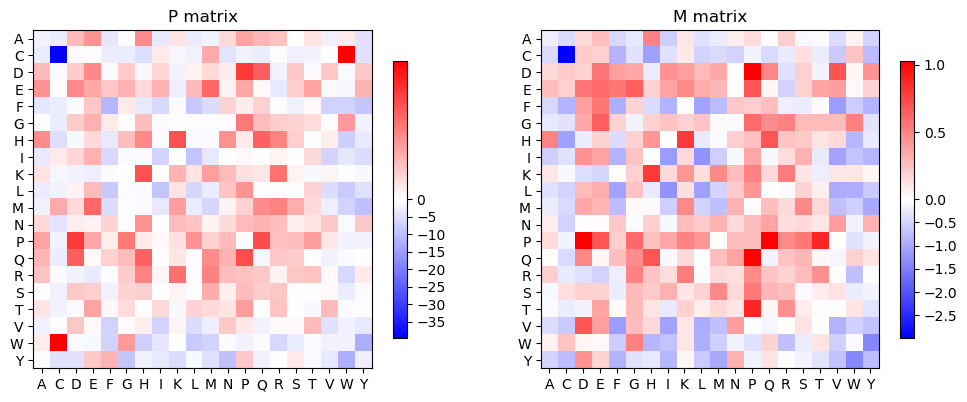

In [11]:
p_matrix = np.array(p_matrix)
m_matrix = np.array(m_matrix)

# Plot the M and P matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
divnorm = colors.TwoSlopeNorm(vmin=np.amin(p_matrix), vcenter=0.,
                              vmax=np.amax(p_matrix))  # center the colormap (white) to 0
img = axes[0].imshow(p_matrix, interpolation="none", cmap='bwr', norm=divnorm)
axes[0].set_title('P matrix')
axes[0].set_xticks([i for i, aa in enumerate(aa_list)])
axes[0].set_xticklabels(aa_list)
axes[0].set_yticks([i for i, aa in enumerate(aa_list)])
axes[0].set_yticklabels(aa_list)
fig.colorbar(img, ax=axes[0], shrink=0.6)

divnorm = colors.TwoSlopeNorm(vmin=np.amin(m_matrix), vcenter=0.,
                              vmax=np.amax(m_matrix))  # center the colormap (white) to 0
img = axes[1].imshow(m_matrix, interpolation="none", cmap='bwr', norm=divnorm)
axes[1].set_title('M matrix')
axes[1].set_xticks([i for i, aa in enumerate(aa_list)])
axes[1].set_xticklabels(aa_list)
axes[1].set_yticks([i for i, aa in enumerate(aa_list)])
axes[1].set_yticklabels(aa_list)
fig.colorbar(img, ax=axes[1], shrink=0.6)

plt.savefig(path + '/figures/iupred_matrix.png', dpi=300, bbox_inches='tight')

In [12]:
def iupred(seq, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''

    pred = []  # Calculated energy per sequence position
    pred_smooth = []

    indices = [aa_list.index(aa) for aa in list(seq)]  # Transform sequence into indexes as in the P matrix
    for i, aa_index in enumerate(indices):

        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = max(0, i - window_size)
        end_before = max(0, i - sequence_separation)
        start_after = min(len(indices) - 1, i + sequence_separation)
        end_after = min(len(indices) - 1, i + window_size)
        indices_local = indices[start_before: end_before] + indices[start_after: end_after]
        print(i, aa_index, aa_list[aa_index], len(indices), len(indices_local), start_before, end_before, start_after, end_after)

        # Count the different amino acids in the window
        row = np.full((20,), 0)
        for index in indices_local:
            row[index] += 1
        print(row)

        # calculate AA frequency
        row = row / len(indices_local)  
        print(row)

        # calculate energy
        row = row * p_matrix[aa_index, ]  
        print(row)

        aa_energy = np.sum(row)
        print(i, seq[i], aa_energy)

        pred.append(aa_energy)

    # Smooth the prediction (moving average)
    for i in range(len(pred)):
        frag = pred[max(0, i - window_size_smooth): min(i + window_size_smooth, len(pred))]
        pred_smooth.append(sum(frag) / len(frag))

    return pred, pred_smooth

1qjt A LSLTQLSSGNPVYEKYYRQVEAGNTGRVLALDAAAFLKKSGLPDLILGKIWDLADTDGKGVLSKQEFFVALRLVACAQNGLEVSLSSLSLAVPPPRFHD
0 9 L 99 96 0 0 2 98
[10  1  5  4  4  8  1  2  6 16  0  3  5  4  4  8  3  8  1  3]
[0.10416667 0.01041667 0.05208333 0.04166667 0.04166667 0.08333333
 0.01041667 0.02083333 0.0625     0.16666667 0.         0.03125
 0.05208333 0.04166667 0.04166667 0.08333333 0.03125    0.08333333
 0.01041667 0.03125   ]
[-0.31354167 -0.02239583  0.01197917  0.0475     -0.35791667 -0.04583333
 -0.00895833 -0.18770833  0.030625   -1.06166667 -0.          0.0303125
  0.09427083 -0.02416667 -0.025      -0.03416667  0.0225     -0.4525
 -0.0865625  -0.153125  ]
0 L -2.5363541666666665
1 15 S 99 95 0 0 3 98
[10  1  5  4  4  8  1  2  6 15  0  3  5  4  4  8  3  8  1  3]
[0.10526316 0.01052632 0.05263158 0.04210526 0.04210526 0.08421053
 0.01052632 0.02105263 0.06315789 0.15789474 0.         0.03157895
 0.05263158 0.04210526 0.04210526 0.08421053 0.03157895 0.08421053
 0.01052632 0.03157895]
[-0.00842105 -0

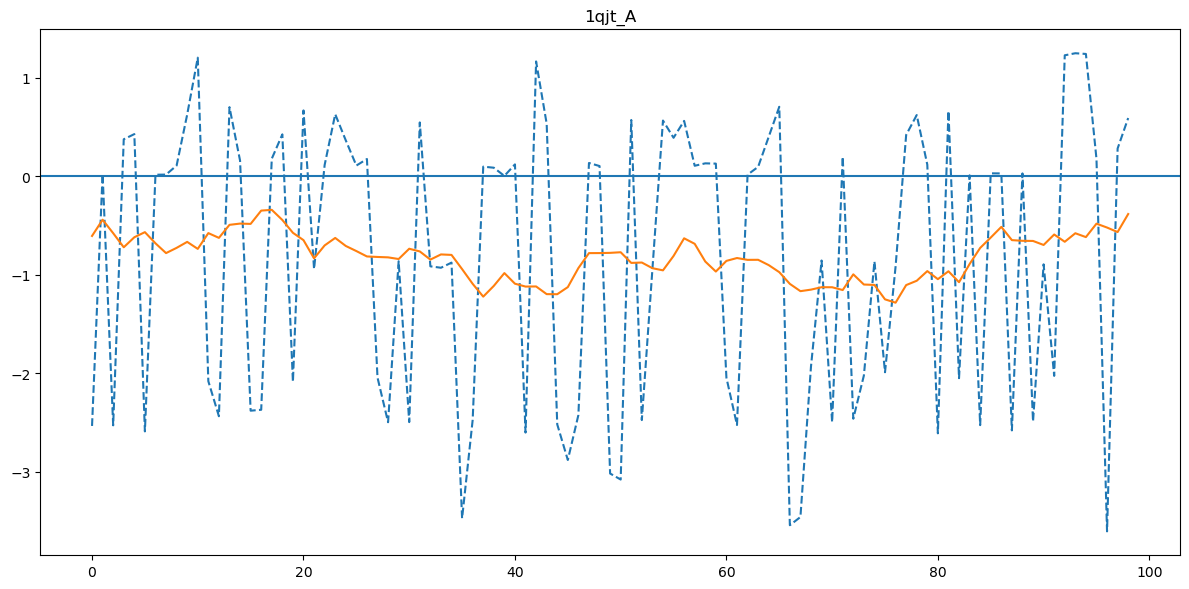

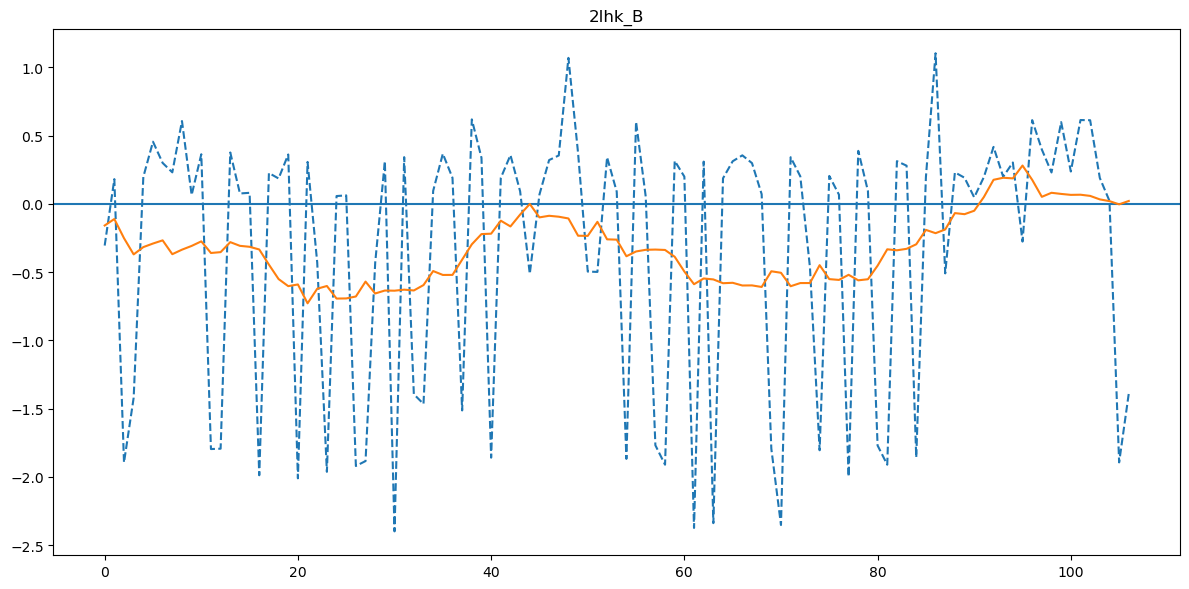

In [13]:
# IUPRED prediction
pdb_ids = [('1qjt', 'A'), ('2lhk', 'B')]

pdbl = PDBList()
for pdb_id, chain_id in pdb_ids:

  pdbl.retrieve_pdb_file(pdb_id, pdir=path + "/pdb", file_format='pdb')
  structure = PDBParser(QUIET=True).get_structure(pdb_id, path + "/pdb/pdb{}.ent".format(pdb_id))
  residues = [residue for residue in structure[0][chain_id] if residue.id[0] == " "]
  seq = "".join([seq1(residue.get_resname()) for residue in residues])
  print(pdb_id, chain_id, seq)

  # Generate the prediction
  pred, pred_smooth = iupred(seq)  
  
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_title("{}_{}".format(pdb_id, chain_id))
  ax.axhline()
  ax.plot(np.arange(len(seq)), pred, ls='--')
  ax.plot(np.arange(len(seq)), pred_smooth, ls='-')
  plt.tight_layout()  # Remove figure padding
  plt.savefig(path + '/figures/iupred_{}_{}.png'.format(pdb_id, chain_id), dpi=300, bbox_inches='tight')

  

MSDASLRSTSTMERLVARGTFPVLVRTSACRSLFGPVDHEELSRELQARLAELNAEDQNRWDYDFQQDMPLRGPGRLQWTEVDSDSVPAFYRETVQVGRCRLLLAPRPVAVAVAVSPPLEPAAESLDGLEEAPEQLPSVPVPAPASTPPPVPVLAPAPAPAPAPVAAPVAAPVAVAVLAPAPAPAPAPAPAPAPVAAPAPAPAPAPAPAPAPAPAPDAAPQESAEQGANQGQRGQEPLADQLHSGISGRPAAGTAAASANGAAIKKLSGPLISDFFAKRKRSAPEKSSGDVPAPCPSPSAAPGVGSVEQTPRKRLR
0 10 M 316 98 0 0 2 100
[ 7  2  8  8  4  5  1  0  0 10  2  2  5  6 12  8  6  8  2  2]
[0.07142857 0.02040816 0.08163265 0.08163265 0.04081633 0.05102041
 0.01020408 0.         0.         0.10204082 0.02040816 0.02040816
 0.05102041 0.06122449 0.12244898 0.08163265 0.06122449 0.08163265
 0.02040816 0.02040816]
[-0.14857143  0.02918367  0.04979592  0.20653061 -0.21795918 -0.02653061
 -0.00765306 -0.          0.         -0.29387755 -0.13244898  0.00428571
  0.03826531  0.11632653  0.25591837  0.11346939  0.03857143 -0.21142857
 -0.14040816 -0.19857143]
0 M -0.5251020408163265
1 15 S 316 98 0 0 3 101
[ 7  2  7  8  4  5  1  0  0 10  2  2  5  6 13  8  6  8  2  2]
[0.07142857 0.020

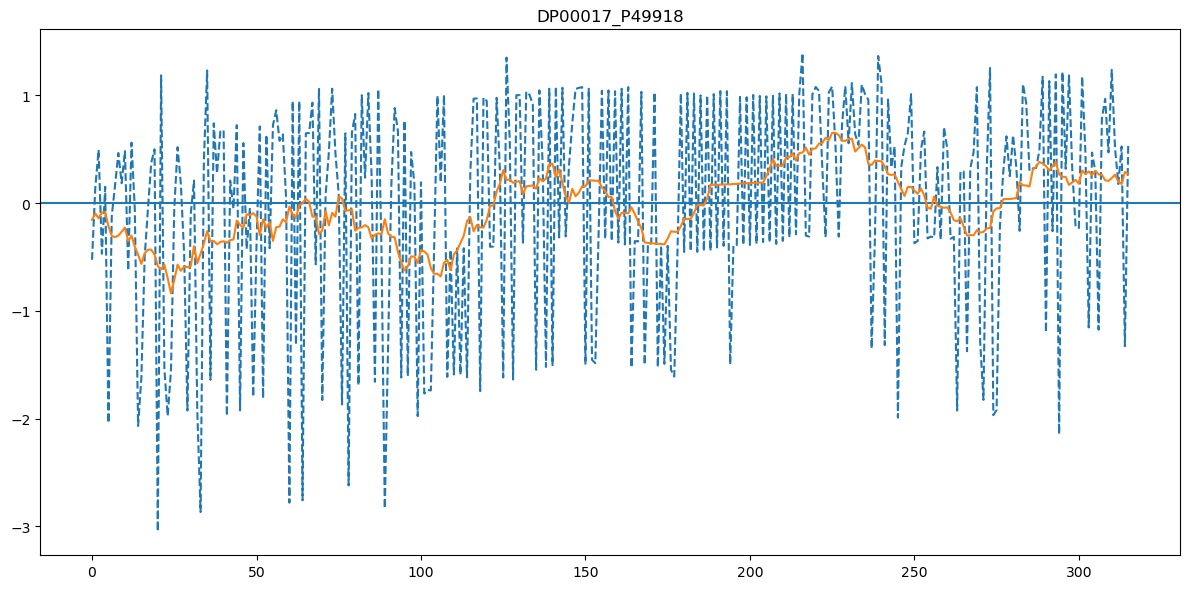

In [14]:
seq = "MSDASLRSTSTMERLVARGTFPVLVRTSACRSLFGPVDHEELSRELQARLAELNAEDQNRWDYDFQQDMPLRGPGRLQWTEVDSDSVPAFYRETVQVGRCRLLLAPRPVAVAVAVSPPLEPAAESLDGLEEAPEQLPSVPVPAPASTPPPVPVLAPAPAPAPAPVAAPVAAPVAVAVLAPAPAPAPAPAPAPAPVAAPAPAPAPAPAPAPAPAPAPDAAPQESAEQGANQGQRGQEPLADQLHSGISGRPAAGTAAASANGAAIKKLSGPLISDFFAKRKRSAPEKSSGDVPAPCPSPSAAPGVGSVEQTPRKRLR"
print(seq)
pdb_id = "DP00017"
chain_id = "P49918"

pred, pred_smooth = iupred(seq)  # prediction

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("{}_{}".format(pdb_id, chain_id))
ax.axhline()
ax.plot(np.arange(len(seq)), pred, ls='--')
ax.plot(np.arange(len(seq)), pred_smooth, ls='-')
plt.tight_layout()  # Remove figure padding
plt.savefig(path + '/figures/iupred_{}_{}.png'.format(pdb_id, chain_id), dpi=300, bbox_inches='tight')